In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    #print (pairs[:10])
    # Reverse pairs, make Lang instances

    return pairs

In [5]:
MAX_LENGTH_WORDS = 10


def filterPair(p):
    #print(p[0] + " " + p[1])
    return len(p[0].split(' ')) < MAX_LENGTH_WORDS and \
        len(p[1].split(' ')) < MAX_LENGTH_WORDS 


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
import random

def prepareData(lang1, lang2, reverse=False):
    pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    return pairs

def prepairTrainSeq():
    pairs = prepareData('eng', 'rus', True)
    target_strings = [pair[0] for pair in pairs]
    input_strings = [pair[1] for pair in pairs]
    return target_strings, input_strings

target_strings, input_strings = prepairTrainSeq()

#i need that for tokenizer
ru_text = ""
en_text = ""
for p in input_strings:
    ru_text += p + '\n'
for p in target_strings:
    en_text += p + '\n'

# calculate 10% of the total number of elements in pairs
# randomly select n elements from pairs and move them to val set\n",
print("making validation set")
combined_list = list(zip(target_strings, input_strings))
random.shuffle(combined_list)
target_strings, input_strings = zip(*combined_list)

n = int(len(input_strings) * 0.1)

train_target_strings = target_strings[n:]
train_input_strings = input_strings[n:]

val_target_strings = target_strings[n:]
val_input_strings = input_strings[n:]

print("train data")
print("input data: ")
for s in train_input_strings[:10]:
    print(s)

print("target data")
for s in train_target_strings[:10]:
    print(s)
    
print("validation data")
print("input data: ")
for s in val_input_strings[:10]:
    print(s)

print("target data")
for s in val_target_strings[:10]:
    print(s)
print("validation set len = " + str(len(val_input_strings)))
print("train set len      = " + str(len(train_input_strings)))


Reading lines...
Read 330194 sentence pairs
Trimmed to 277796 sentence pairs
Counting words...
making validation set
train data
input data: 
почему вы жили в австралии в прошлом году ?
я опоздал на реис .
я в этом никого не виню .
даваи сделаем последнее усилие .
я слышал как вы плакали .
мы не должны терять надежду .
как вы переносите этот холод ?
нам не везло .
я не смог бы так жить .
ты сеичас куда ?
target data
why did you live in australia last year ?
i missed my flight .
i m not blaming anyone for it .
let s make one last effort .
i heard you crying .
we shouldn t lose hope .
how do you stand this cold ?
we weren t lucky .
i couldn t live like that .
where are you going now ?
validation data
input data: 
почему вы жили в австралии в прошлом году ?
я опоздал на реис .
я в этом никого не виню .
даваи сделаем последнее усилие .
я слышал как вы плакали .
мы не должны терять надежду .
как вы переносите этот холод ?
нам не везло .
я не смог бы так жить .
ты сеичас куда ?
target data
wh

In [ ]:
%pip install transformers

In [ ]:
%pip install tokenizers

here I am building the tokenizer

In [9]:
from tokenizers import BertWordPieceTokenizer

In [10]:
print(ru_text[:100])

марш !
иди .
идите .
здравствуите .
привет !
хаи .
здрасте .
здорово !
приветик !
беги !
бегите !
бе


In [11]:
print(en_text[:100])

go .
go .
go .
hi .
hi .
hi .
hi .
hi .
hi .
run !
run !
run .
run .
who ?
wow !
wow !
wow !
wow !
w


In [12]:
SOS_token = 0
EOS_token = 1

def create_tokenizer_from_text(text):
    # Create new tokenizer based on input text
    tokenizer = BertWordPieceTokenizer(
        clean_text=True,
        handle_chinese_chars=False,
        strip_accents=False,
        lowercase=False
        )
    tokenizer.add_tokens(["[SOS]"])#Вот прям 100% тут можно как-то отстрелить себе ногу
    tokenizer.add_tokens(["[EOS]"])
    tokenizer.train_from_iterator([text.split()], vocab_size=5000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
    # Return tokenizer object
    return tokenizer

In [13]:
ru_tokenizer = create_tokenizer_from_text(ru_text)
en_tokenizer = create_tokenizer_from_text(en_text)

In [14]:
ru_tokenizer.save("ru_tokenizer.json")
en_tokenizer.save("en_tokenizer.json")

In [15]:
ru_tokenizer.get_vocab()

{'мальчик': 1900,
 'прежнему': 2990,
 '##ресси': 4114,
 'наеди': 4866,
 'шахматы': 3502,
 'па': 452,
 'объяснить': 2132,
 '##лагода': 1593,
 'кататься': 3019,
 'дерево': 2123,
 'должна': 1517,
 '##тым': 2479,
 '##ких': 1228,
 '##ении': 1016,
 'мест': 4483,
 'купил': 821,
 '##рован': 4791,
 '##фор': 2004,
 'твою': 2120,
 '##рая': 2966,
 '##ское': 3164,
 'докто': 4133,
 '##циеи': 4992,
 'работали': 4826,
 'попал': 4126,
 'терпеть': 2567,
 'спросил': 3051,
 'увер': 654,
 'принад': 2425,
 '##лю': 277,
 '##рели': 2857,
 'сплю': 3857,
 'сохра': 3569,
 'искус': 3931,
 'повы': 3874,
 'осу': 4804,
 'слово': 2056,
 '##рабо': 1488,
 'смогла': 4890,
 'друзеи': 1687,
 'сэ': 4973,
 'равно': 2129,
 'баскет': 4371,
 '##ально': 1290,
 'дать': 2115,
 'вряд': 3902,
 'ненадолго': 4112,
 'нас': 323,
 'украли': 2988,
 '##ялись': 2463,
 'забыть': 3487,
 '##лении': 4196,
 'ждет': 4330,
 '##гия': 3241,
 '##чу': 265,
 'япо': 1153,
 'проснулся': 4262,
 'две': 1325,
 'утро': 2384,
 'сказали': 1102,
 'заму': 1405,

In [16]:
en_tokenizer.get_vocab_size()

5002

In [17]:
ru_tokenizer.get_vocab_size()

5002

In [18]:
ru_tokenizer.encode(train_input_strings[1]).tokens

['я', 'опоздал', 'на', 'ре', '##и', '##с', '.']

In [19]:
en_tokenizer.encode(train_target_strings[1]).tokens

['i', 'missed', 'my', 'flight', '.']

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
MAX_LENGTH = 300

In [23]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
def tensorFromSentence(tokenizer, sentence):
    indexes = tokenizer.encode(sentence).ids
    indexes.append(EOS_token)
    indexes = torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    return indexes

In [25]:
#teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    if(input_length >= MAX_LENGTH ):
        input_length = (MAX_LENGTH - 1) #better to lose some tokens than fail
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [26]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#converting strings to tensors

In [27]:
train_input_tensors = []
train_target_tensors = []
for i in train_input_strings:
    train_input_tensors.append(tensorFromSentence(ru_tokenizer, i))
for i in train_target_strings:
    train_target_tensors.append(tensorFromSentence(en_tokenizer, i))

In [28]:
#checking if everything is fine
n = 256
print("input: " + ru_tokenizer.decode(train_input_tensors[n].squeeze(-1).tolist()))
print("target: " + en_tokenizer.decode(train_target_tensors[n].squeeze(-1).tolist()))

input: мы оба победили.
target: we both won.


In [29]:
import numpy as np
plot_losses = []
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, save_every=1000, batch_size = 200):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate, weight_decay = 0.0001 )
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate, weight_decay = 0.0001 )
    
    criterion = nn.NLLLoss()    
    for iter in range(1, n_iters + 1):
        print(f'{iter} of {n_iters}', end='\r')
        loss  = 0
        for i in range(batch_size):
            n = random.randint(0, lens(train_input_tensors)-1)
            input_tensor = train_input_tensors[n]
            target_tensor = train_target_tensors[n]
            #print("debug")
            #print("input: " + ru_tokenizer.decode(input_tensor.squeeze(-1).tolist()))
            #print("target: " + en_tokenizer.decode(target_tensor.squeeze(-1).tolist()))
            loss += train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += (loss/batch_size)
        plot_loss_total += (loss/batch_size)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % save_every == 0:
            model_file_name = f'weights/encoder/model_weights_{iter}.pth'
            print(f'Saving model as {model_file_name}')
            torch.save(encoder, model_file_name)
            model_file_name = f'weights/decoder/model_weights_{iter}.pth'
            print(f'Saving model as {model_file_name}')
            torch.save(decoder, model_file_name)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0



In [30]:
%mkdir weights

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘weights’: File exists


In [31]:
%mkdir weights/encoder

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘weights/encoder’: File exists


In [32]:
%mkdir weights/decoder

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘weights/decoder’: File exists


In [33]:
hidden_size = 800
encoder1 = EncoderRNN(ru_tokenizer.get_vocab_size(), hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, en_tokenizer.get_vocab_size(), dropout_p=0.5).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=1000, save_every = 10000, batch_size = 10)


4m 20s (- 429m 31s) (1000 1%) 4.1306
8m 47s (- 430m 36s) (2000 2%) 3.4799
13m 17s (- 429m 33s) (3000 3%) 3.1480
17m 48s (- 427m 24s) (4000 4%) 2.9355
22m 17s (- 423m 29s) (5000 5%) 2.7768
26m 45s (- 419m 17s) (6000 6%) 2.6343
31m 16s (- 415m 26s) (7000 7%) 2.5531
35m 45s (- 411m 11s) (8000 8%) 2.4717
40m 18s (- 407m 38s) (9000 9%) 2.4076
45m 10s (- 406m 35s) (10000 10%) 2.3495
Saving model as weights/encoder/model_weights_10000.pth
Saving model as weights/decoder/model_weights_10000.pth
50m 0s (- 404m 36s) (11000 11%) 2.3122
54m 37s (- 400m 33s) (12000 12%) 2.2756
59m 15s (- 396m 34s) (13000 13%) 2.2157
63m 54s (- 392m 36s) (14000 14%) 2.1883
68m 33s (- 388m 27s) (15000 15%) 2.1626
73m 12s (- 384m 20s) (16000 16%) 2.1488
77m 42s (- 379m 24s) (17000 17%) 2.0958
82m 39s (- 376m 34s) (18000 18%) 2.0695
87m 40s (- 373m 44s) (19000 19%) 2.0495
92m 40s (- 370m 42s) (20000 20%) 2.0189
Saving model as weights/encoder/model_weights_20000.pth
Saving model as weights/decoder/model_weights_20000.p

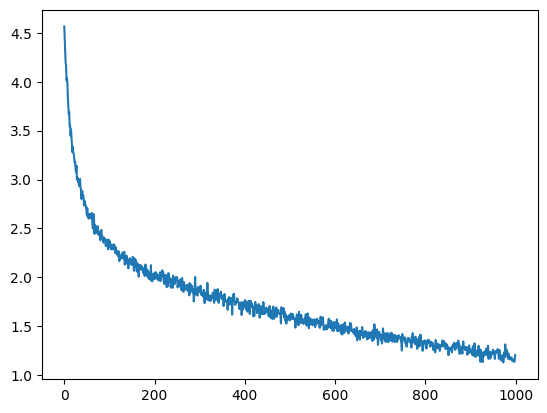

In [34]:
#%pip install matplotlib
import matplotlib.pyplot as plt
#showPlot(plot_losses)
plt.plot(plot_losses)
plt.show()

In [ ]:
encoder1 = torch.load("./weights/encoder/model_weights_60000.pth")
attn_decoder1 = torch.load("./weights/decoder/model_weights_60000.pth")

In [35]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(ru_tokenizer, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        #print(input_tensor)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            #print(topv.item())
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_tokenizer.id_to_token(topi.item()))

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [60]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        #pair = random.choice(val_pairs)
        #pair = random.choice(pairs)
        n = random.randint(0, len(val_input_strings))
        print('>', val_input_strings[n])
        print('=', val_target_strings[n])
        output_words, attentions = evaluate(encoder, decoder, val_input_strings[n])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [61]:
evaluateRandomly(encoder1, attn_decoder1,10)

> она любит синие платья .
= she likes blue dresses .
< she likes blue dress . . <EOS>

> ты не смотришь телевизор ?
= don t you watch tv ?
< don t you watch tv ? <EOS>

> ты должен только дождаться ее возвращения .
= you have only to wait for her return .
< you must only to wait to to return . <EOS>

> с самого утра идет снег .
= it s been snowing since this morning .
< it s been been snow since morning morning . <EOS>

> я знаю несколько канадцев .
= i know several canadians .
< i know a canadians . <EOS>

> взобраться на эту крутую гору физически невозможно .
= climbing that steep mountain is a physical impossibility .
< climb mountain climb to mountain mountain mountain ##ical ##ical . <EOS>

> можно мне одолжить ваш словарь ?
= may i borrow your dictionary ?
< could i borrow your dictionary ? <EOS>

> какие у нас шансы ?
= what are our chances ?
< what are our chance ##s ? <EOS>

> спасибо что дали мне знать .
= thanks for letting me know .
< thanks for let ##ting me know . <EOS>


In [62]:
evaluateRandomly(encoder1, attn_decoder1,10)

> она решила выити за него .
= she decided to marry him .
< she decided to go him . <EOS>

> я лучше сегодня останусь дома .
= i d rather stay at home today .
< i d better home home today . <EOS>

> было время обеда .
= it was time for lunch .
< it was a lunch . <EOS>

> я не могу сделать это сеичас .
= i can t do it now .
< i can t do it now . <EOS>

> проверьте все еще раз .
= check everything one more time .
< check everything again . <EOS>

> мы оба пошли на жертвы .
= we ve both made sacrifices .
< we re both went the the ##s . . . <EOS>

> ты себя выдашь .
= you ll give yourself away .
< you ll give yourself . <EOS>

> оно у меня .
= i have it .
< it have it . <EOS>

> я должен знать .
= i ve got to know .
< i have to know . <EOS>

> уже одиннадцать часов .
= it is already eleven .
< it is already eleven clock . . <EOS>



In [43]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    input_sentence = input_sentence.lower()
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

def translate(input_sentence):
    input_sentence = input_sentence.lower()
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input = ', input_sentence)
    print('output =', ' '.join(output_words))


In [44]:
translate("I am playing")

input =  i am playing
output = the in ##le the the the the <EOS>


In [45]:
translate("я чувствую себя хорошо")

input =  я чувствую себя хорошо
output = i feel fine well . <EOS>


In [46]:
translate("Она смотрит телевизор")

input =  она смотрит телевизор
output = she is watching tv tv <EOS>


In [47]:
translate("я смотрю телевизор")

input =  я смотрю телевизор
output = i watch television television <EOS>


In [48]:
translate("я еду на автобусе")

input =  я еду на автобусе
output = i m going to bus . <EOS>


In [49]:
translate("я еду на машине")

input =  я еду на машине
output = i m on my car <EOS>


In [50]:
translate("ты смотришь телевизор")

input =  ты смотришь телевизор
output = you watch tv tv <EOS>


In [51]:
translate("Я играю на гитаре")

input =  я играю на гитаре
output = i play the guitar <EOS>


In [52]:
translate("У нас нет времени ждать")

input =  у нас нет времени ждать
output = we don no have time to wait <EOS>


In [53]:
translate("Я играю на трубе")

input =  я играю на трубе
output = i play tru ##et ##et ##et <EOS>


In [54]:
translate("Куда вы идете")

input =  куда вы идете
output = where you going going <EOS>


In [55]:
translate("я не сплю")

input =  я не сплю
output = i m awake . <EOS>


In [64]:
translate("я сплю")

input =  я сплю
output = i sleep sleep <EOS>


In [65]:
translate("я сплю очень хорошо")

input =  я сплю очень хорошо
output = i sleep very well . <EOS>


In [66]:
translate("я сплю очень плохо")

input =  я сплю очень плохо
output = i sleep very very bad . <EOS>


In [56]:
translate("я ем")

input =  я ем
output = i m eating . <EOS>


In [63]:
translate("Тойота")

input =  тойота
output = it s <EOS>


In [67]:
import pickle

def save_tuple_to_file(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)


In [69]:
save_tuple_to_file("val_input_strings", val_input_strings)

In [70]:
save_tuple_to_file("val_target_strings", val_input_strings)

In [71]:
save_tuple_to_file("train_input_strings", train_input_strings)

In [72]:
save_tuple_to_file("train_target_strings", train_target_strings)